## Install Dependencies and Stable Baselines Using Pip

List of full dependencies can be found in the [README](https://github.com/hill-a/stable-baselines).

```
sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev
```


```
pip install stable-baselines[mpi]
```

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#! pip install keras==2.3.1

In [24]:
# Stable Baselines only supports tensorflow 1.x for now
#!pip install tensorflow==1.15.0
%tensorflow_version 1.x
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines[mpi]==2.10.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


## Imports

In [25]:
import gym
import pickle
import torch as th
import torch.nn as nn
import os
import time

import stable_baselines
stable_baselines.__version__
from stable_baselines import DQN
#from stable_baselines.common.callbacks import BaseCallback

## Resolvendo os problemas da seed

In [26]:
seed_value = 12345

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
#seed_value += 1

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
#seed_value += 1

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
#seed_value += 1

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)



# 5. Configure a new global `tensorflow` session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)


## Limpando pastas locais

In [27]:
#!rm -rf logs
#!rm -rf results
#!rm -rf videos

## Parâmetros e paths

In [28]:
# AQUI
agent = 'DQN-cartPole'
enviroment = 'CartPole-v1'

timestr = time.strftime("%Y%m%d-%H%M%S")

experiment_name = agent + '_' + timestr

os.makedirs(experiment_name)

results_path = experiment_name + '/results_' + experiment_name
logdir = experiment_name + '/logs_' + experiment_name
videodir = experiment_name + '/videos_' + experiment_name

os.makedirs(results_path)
os.makedirs(logdir)
os.makedirs(videodir)



param_model = {
    'double_q': False, 
    'prioritized_replay': False,
    'gamma': 0.99,
    'learning_rate': 0.0005,
    'buffer_size': 100000,
    'exploration_fraction': 0.1, 
    'exploration_final_eps': 0.02,
    'exploration_initial_eps': 0.1,
    'target_network_update_freq': 500,
    'prioritized_replay_alpha': 0.6,
    'prioritized_replay_beta0': 0.4,
    'prioritized_replay_beta_iters':None,
    'prioritized_replay_eps': 1e-06,
    'param_noise': False,
    'learning_starts': 1000,
    'batch_size': 32,
    'train_freq': 1,
    'policy_kwargs': None,
    'verbose': 1,
    'seed': seed_value,
    'n_cpu_tf_sess': 1 
    }

param_learning = {
    'total_timesteps': 10000,
    'callback': None,
    'log_interval': 10
}


log = {**param_model, **param_learning}

param_model['policy_kwargs'] = dict(dueling=False)


## Implementação de callbacks e evaluate

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    win = 0
    loss = 0
    for i in range(num_episodes):
        #print(f'episode {i}')
        episode_rewards = []
        done = False
        lives = 0
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs, deterministic=True)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
             
        all_episode_rewards.append(sum(episode_rewards))
        if (all_episode_rewards[-1] >= 350):
          win += 1
        else:
          loss += 1 

        #print(f'reward total: {all_episode_rewards[-1]}')
    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)
  
    return all_episode_rewards, win, loss

## Políticas customizadas aqui

In [30]:
from stable_baselines.deepq.policies import FeedForwardPolicy

class simpleMLP(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(simpleMLP, self).__init__(*args, **kwargs,
                                           layers=[32, 32],
                                           layer_norm=False,
                                           feature_extraction="mlp")
        
class mediumMLP(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(mediumMLP, self).__init__(*args, **kwargs,
                                           layers=[128, 64],
                                           layer_norm=False,
                                           feature_extraction="mlp")

class normMLP(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(normMLP, self).__init__(*args, **kwargs,
                                           layers=[64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp",)  

#AQUI ------ LEMBRAR DE COLOCAR O NOME DA FUNCAO OU DA POLITICA JA DEFINIDA PELA BIBLIOTECA 
policy_name = 'LnMlpPolicy'   #ESSA VARIAVEL TEM O NOME DA POLITICA QUE SERA USADA
log['policy_name'] = policy_name


## Model and Train

Mean reward: 11.57 Num episodes: 100


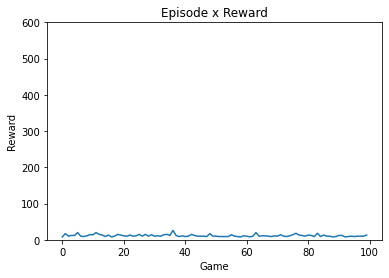

In [31]:
import matplotlib.pyplot as plt
##ESSA
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
import time

env = gym.make(enviroment)
env.seed(seed_value)

eval_env = gym.make(enviroment)
env.seed(seed_value)



best_model_path = os.path.join(results_path, 'best_model')
#####ESSA
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=500, verbose=1)
####ESSA
eval_callback = EvalCallback(eval_env, best_model_save_path=best_model_path,
                             callback_on_new_best=callback_on_best,
                             log_path=logdir, eval_freq=100,
                             deterministic=True, render=False)

param_learning['callback'] = eval_callback

#PASSA O POLICY NAME OU O NOME DA FUNCAO: POLICY NAME APENAS SE JÁ FOR PADRAO 
dqn_model = DQN(policy_name, env, **param_model, tensorboard_log=logdir)
#dqn_model = DQN(simpleMLP, env, **param_model, tensorboard_log=logdir)
dqn_model.set_random_seed(seed=seed_value)

# Random Agent, before training
all_episode_reward_before_train, win, loss = evaluate(dqn_model, num_episodes=100)

log['all_reward_before_train'] = all_episode_reward_before_train

plt.plot(all_episode_reward_before_train)
plt.ylabel('Reward')
plt.xlabel('Game')
plt.title('Episode x Reward')
plt.ylim(0, 600)
plt.show()

In [32]:

#### Treina
start_time = time.time()
dqn_model.learn(**param_learning)
log['time'] = (time.time() - start_time) 
print('Fininsh --- %s seconds --- ' % log['time'])


/usr/local/lib/python3.6/dist-packages/stable_baselines/common/callbacks.py:277: UserWarning: Training and eval env are not of the same type<TimeLimit<CartPoleEnv<CartPole-v1>>> != <stable_baselines.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fa945f62860>
  "{} != {}".format(self.training_env, self.eval_env))


Eval num_timesteps=100, episode_reward=12.80 +/- 5.64
Episode length: 12.80 +/- 5.64
New best mean reward!
--------------------------------------
| % time spent exploring  | 9        |
| episodes                | 10       |
| mean 100 episode reward | 13.3     |
| steps                   | 120      |
--------------------------------------
Eval num_timesteps=200, episode_reward=12.00 +/- 3.29
Episode length: 12.00 +/- 3.29
--------------------------------------
| % time spent exploring  | 7        |
| episodes                | 20       |
| mean 100 episode reward | 13.5     |
| steps                   | 257      |
--------------------------------------
Eval num_timesteps=300, episode_reward=11.80 +/- 2.23
Episode length: 11.80 +/- 2.23
--------------------------------------
| % time spent exploring  | 6        |
| episodes                | 30       |
| mean 100 episode reward | 13.6     |
| steps                   | 395      |
--------------------------------------
Eval num_timesteps=40

## Avaliando o agente treinado

Mean reward: 500.0 Num episodes: 100


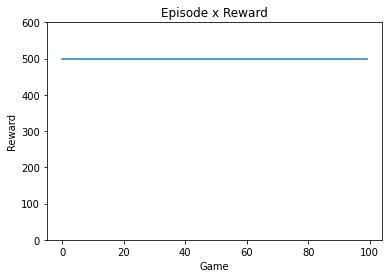

Mean reward: 500.0 Std reward: 0.0
win: 100 loss: 0


In [33]:
log['rewards'], log['win'], log['loss']  = evaluate(dqn_model, num_episodes=100)
log['mean'] = np.mean(log['rewards'])
log['std'] = np.std(log['rewards'])

plt.plot(log['rewards'])
plt.ylabel('Reward')
plt.xlabel('Game')
plt.title('Episode x Reward')
plt.ylim(0, 600)
plt.show()

print("Mean reward:", log['mean'], "Std reward:", log['std'])
print("win:", log['win'], "loss:", log['loss'])


## Funções auxiliares para video


In [34]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [35]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', name=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(name)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [36]:
from stable_baselines.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=1000, prefix='', video_folder= videodir):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(enviroment)])
  # Start the video at step=0 and record X steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

### Visualizando o agente treinado

In [37]:
def save_log(log, agent, path, experiment_name):
  #path = os.path.abspath(os.getcwd())
  #path = os.path.join(path, 'results')
  print('Save log in %s ' % path)
  #timestr = time.strftime("%Y%m%d-%H%M%S")
  name_file = experiment_name + '.pkl'
  name_file = os.path.join(path, name_file)
  if not os.path.exists(path):
      os.makedirs(path)
  a_file = open(name_file, "wb")
  pickle.dump(log, a_file)
  a_file.close()

  name_file = experiment_name
  #salvando o video
  record_video(enviroment, dqn_model, video_length=6000, prefix=name_file, video_folder=videodir)
  print('video - Saving local')
  #mostrando o video salvo
  show_videos(videodir, name=name_file)


In [ ]:
save_log(log, agent, results_path, experiment_name)

Save log in DQN-cartPole_20210125-190415/results_DQN-cartPole_20210125-190415 


## TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "$experiment_name"/logs_"$experiment_name"

In [ ]:
!cp -r "$experiment_name" /content/drive/MyDrive/T2_ReinforcementLearning/Results/

In [ ]:
#!tensorboard dev upload \
#  --logdir logs \
#  --name "(optional) My latest experiment" \
#  --description "(optional) Simple comparison of several hyperparameters" \
#  --one_shot